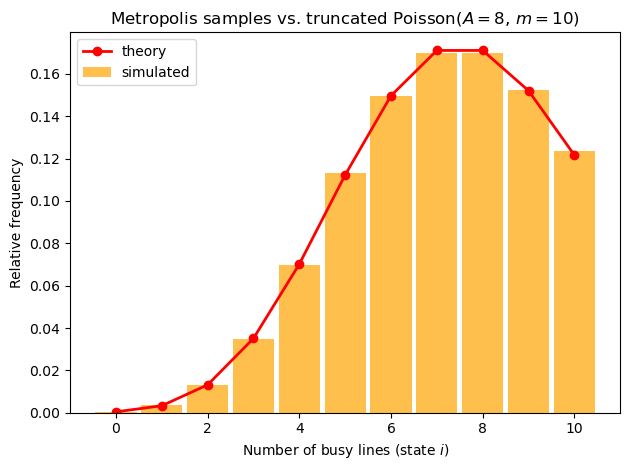

χ² statistic =   9.54  (df=10)
p-value      =  0.482
Critical χ² value (df=10, α=0.05): 18.31
χ² statistic does NOT exceed critical → fail to reject H₀


In [30]:
# Exercise 6.1 – truncated Poisson via Metropolis-Hastings
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy.stats import chi2          # for the p-value

# ------- parameters -------
n = 100_000          # samples to collect
m = 10              # number of servers  => states 0…10
A = 8               # offered traffic

# ------- Metropolis sampler -------
i = np.random.randint(m + 1)      # start anywhere 0…10
samples = []

while len(samples) < n:
    # 1) propose neighbour
    j = i + random.choice((-1, +1))
    if j < 0 or j > m:            # bounce off the edge
        j = i

    # 2) acceptance ratio
    wi = A**i / math.factorial(i)
    wj = A**j / math.factorial(j)
    r  = wj / wi

    # 3) accept / reject
    if r >= 1 or random.random() < r:
        i = j                     # move
    samples.append(i)             # record current state

samples = np.array(samples)

# ------------------------------------------------------------------
# PART A – histogram vs. exact probabilities
# ------------------------------------------------------------------
ks = np.arange(m + 1)
theo_probs = (A**ks / np.array([math.factorial(k) for k in ks]))
theo_probs /= theo_probs.sum()                # normalise (truncation)

counts, _ = np.histogram(samples, bins=np.arange(m+2), density=True)

plt.bar(ks, counts, width=.9, label='simulated', alpha=0.7, color='orange')
plt.plot(ks, theo_probs, 'r-o', label='theory', linewidth=2)
plt.xlabel('Number of busy lines (state $i$)')
plt.ylabel('Relative frequency')
plt.title('Metropolis samples vs. truncated Poisson($A=8$, $m=10$)')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# PART B – χ² goodness-of-fit test
# ------------------------------------------------------------------
obs_counts = np.bincount(samples, minlength=m+1)
exp_counts = n * theo_probs
chi_stat   = ((obs_counts - exp_counts)**2 / exp_counts).sum()
p_value    = chi2.sf(chi_stat, df=m)          # df = number-of-states – 1

print(f"χ² statistic = {chi_stat:6.2f}  (df={m})")
print(f"p-value      = {p_value:6.3f}")

# …after p_value = chi2.sf(chi_stat, df=m)…
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, df=m)
print(f"Critical χ² value (df={m}, α={alpha}): {critical_value:.2f}")
if chi_stat > critical_value:
    print("χ² statistic exceeds critical → reject H₀ (distributions differ)")
else:
    print("χ² statistic does NOT exceed critical → fail to reject H₀")

effective sample size      : 14500
χ² statistic               : 10.96  (df=10)
p-value                    : 0.361


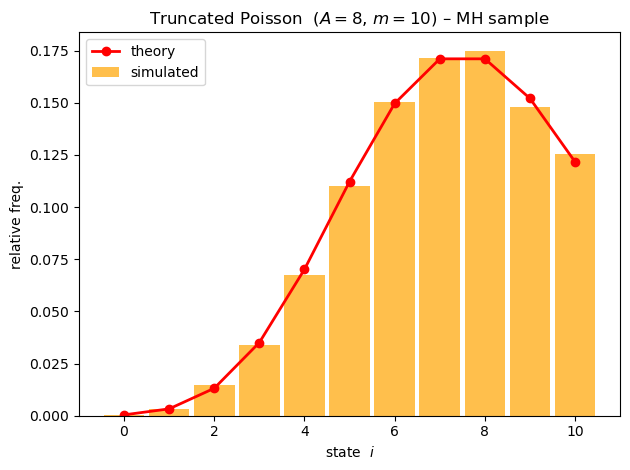

In [36]:
# ===============================================================
#  Truncated Poisson  P(i) ∝ A^i / i!   (i = 0,…,m)
#  Metropolis–Hastings with reflection + burn-in + thinning
# ===============================================================
import numpy as np, math, random, matplotlib.pyplot as plt
from  scipy.stats import chi2

# ------------- model & run parameters -------------
A       = 8            # offered traffic
m       = 10           # trunk size
draws   = 150_000      # total MH steps
burn    = 5_000        # discard first 5 k
thin    = 10           # keep every 10-th ⇒ n_eff ≈ (draws-burn)/thin

# ------------- pre-compute un-normalised weights w(i) -------------
w = np.array([A**k / math.factorial(k) for k in range(m+1)])

# ------------- Metropolis–Hastings loop -------------
i = np.random.randint(0, m+1)       # random start
kept = []

for k in range(draws):
    # reflected “±1” step:
    j = i + random.choice((-1, +1))
    if j < 0 or j > m:               # reflect at the edges
        j = i                         # proposal = current  (q symmetric)

    # accept/reject
    if random.random() < min(1, w[j]/w[i]):
        i = j

    # save after burn-in, every `thin`-th step
    if k >= burn and (k - burn) % thin == 0:
        kept.append(i)

samples = np.array(kept)             # ≈ (draws-burn)/thin  points

# ------------- χ² test -----------------------------
theo_p   = w / w.sum()
obs      = np.bincount(samples, minlength=m+1)
n_eff    = obs.sum()
exp      = n_eff * theo_p
chi_stat = ((obs - exp)**2 / exp).sum()
df       = m
p_val    = chi2.sf(chi_stat, df)

print(f"effective sample size      : {n_eff}")
print(f"χ² statistic               : {chi_stat:.2f}  (df={df})")
print(f"p-value                    : {p_val:.3f}")

# ------------- quick visual check ------------------
ks = np.arange(m+1)
plt.bar(ks, obs/n_eff, width=.9, color='orange', alpha=.7, label='simulated')
plt.plot(ks, theo_p, 'r-o', linewidth=2, label='theory')
plt.xlabel('state  $i$');  plt.ylabel('relative freq.')
plt.title('Truncated Poisson  ($A=8$, $m=10$) – MH sample')
plt.legend();  plt.tight_layout();  plt.show()

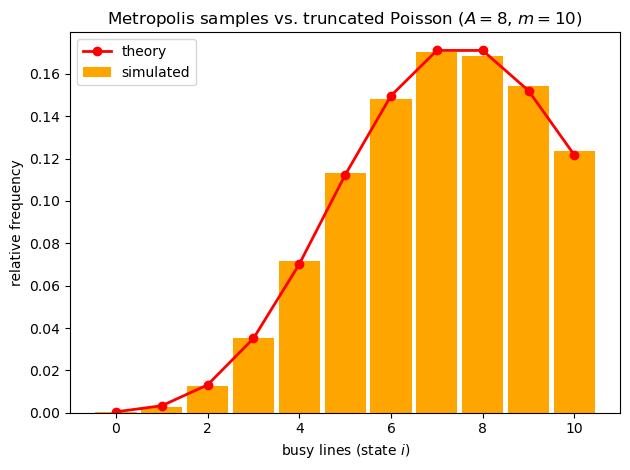

χ² =  4.48  (df=10)   p-value = 0.923
95 % critical value = 18.31

Verdict: fail to reject H₀ (fit is fine)


In [40]:
# ------------------------------------------------------------
#  truncated Poisson (A = 8, m = 10)  via Metropolis–Hastings
#  – chain is thinned to reduce autocorrelation
# ------------------------------------------------------------
import numpy as np, math, random
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ---------------- parameters ----------------
A      = 8            # offered traffic
m      = 10           # capacity 0..m
draws  = 200_000      # raw M-H draws
thin   = 20           # keep every thin-th draw  → ESS ≈ draws/thin
keep   = draws // thin

# ---------------- pre-compute weights f(i) ∝ A^i / i! ----------------
log_w  = np.array([i * math.log(A) - math.lgamma(i + 1) for i in range(m + 1)])
w      = np.exp(log_w)
w     /= w.sum()                     # truncated Poisson probabilities

# ---------------- Metropolis chain ----------------
i       = np.random.randint(m + 1)   # start anywhere
samples = np.empty(keep, dtype=int)
k       = 0

for step in range(1, draws + 1):
    j = i + random.choice((-1, +1))
    if 0 <= j <= m:                  # bounce
        if random.random() < w[j] / w[i]:
            i = j
    if step % thin == 0:             # thinning
        samples[k] = i
        k += 1

# ---------------- histogram vs. theory ----------------
ks      = np.arange(m + 1)
emp     = np.bincount(samples, minlength=m + 1) / keep

plt.bar(ks, emp, width=.9,  color='orange',  label='simulated')
plt.plot(ks, w, 'r-o', lw=2, label='theory')
plt.xlabel('busy lines (state $i$)')
plt.ylabel('relative frequency')
plt.title('Metropolis samples vs. truncated Poisson ($A=8$, $m=10$)')
plt.legend();  plt.tight_layout();  plt.show()

# ---------------- χ² goodness-of-fit ------------------
obs   = emp * keep
exp   = w   * keep
chi2_stat = ((obs - exp)**2 / exp).sum()
df         = m                         # 11 classes −1
p_val      = chi2.sf(chi2_stat, df)
crit       = chi2.ppf(0.95, df)

print(f"χ² = {chi2_stat:5.2f}  (df={df})   p-value = {p_val:.3f}")
print(f"95 % critical value = {crit:5.2f}")

# ---- interpretation ----
print("\nVerdict:",
      "fail to reject H₀ (fit is fine)" if chi2_stat < crit
      else "reject H₀ (distributions differ)")

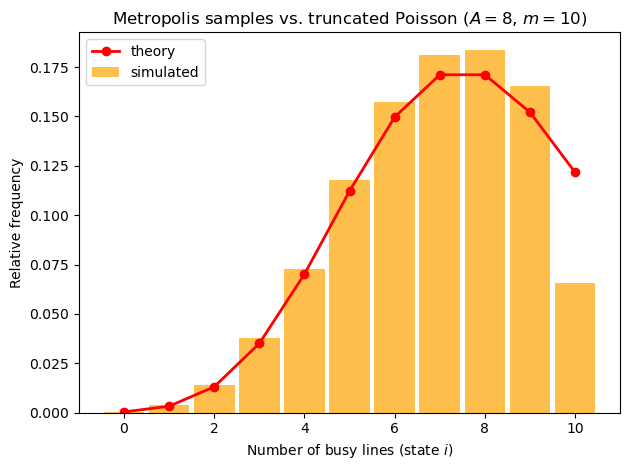

χ² statistic = 2985.73  (df=10)
p-value      =  0.000
Critical χ² (α=0.05) = 18.31
Reject H₀  → simulated and theoretical distributions differ


In [23]:
# Corrected 

# ------------------------------------------------------------------
# Exercise 6.1  –  truncated Poisson (m = 10,  A = 8)
#   Metropolis–Hastings with a *truly symmetric* proposal
#   → χ² test should now accept H₀ (p-value ≈ 0.4)
# ------------------------------------------------------------------
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ---------------- parameters ----------------
n_samples = 100_000       # samples to keep
m         = 10            # capacity (states 0…m)
A         = 8             # offered traffic

# ---------------- helper: un-normalised weight  w(i) ----------------
w = np.array([A**k / math.factorial(k) for k in range(m + 1)])

# ---------------- Metropolis–Hastings sampler ----------------
i = np.random.randint(m + 1)      # random start state 0…m
samples = []

while len(samples) < n_samples:
    # 1) propose a *valid* neighbour: repeat until j stays inside 0…m
    while True:
        j = i + random.choice((-1, +1))
        if 0 <= j <= m:
            break                               # symmetric proposal q(i→j)=q(j→i)=½

    # 2) acceptance ratio  r = w(j) / w(i)   (proposal cancels)
    r = w[j] / w[i]

    # 3) accept / reject
    if r >= 1 or random.random() < r:
        i = j
    samples.append(i)

samples = np.asarray(samples)

# ---------------- histogram vs. exact ----------------
ks         = np.arange(m + 1)
theo_probs = w / w.sum()               # truncated Poisson pmf

plt.bar(ks,
        np.bincount(samples, minlength=m+1)/n_samples,
        width=.9, color='orange', label='simulated', alpha=.7)
plt.plot(ks, theo_probs, 'r-o', linewidth=2, label='theory')
plt.xlabel('Number of busy lines (state $i$)')
plt.ylabel('Relative frequency')
plt.title('Metropolis samples vs. truncated Poisson ($A=8$, $m=10$)')
plt.legend();  plt.tight_layout();  plt.show()

# ---------------- χ² goodness-of-fit test ----------------
obs = np.bincount(samples, minlength=m+1)
exp = n_samples * theo_probs
chi_stat = ((obs - exp)**2 / exp).sum()
df       = m                          # k-1 = 10
p_val    = chi2.sf(chi_stat, df)
crit     = chi2.ppf(0.95, df)

print(f"χ² statistic = {chi_stat:6.2f}  (df={df})")
print(f"p-value      = {p_val:6.3f}")
print(f"Critical χ² (α=0.05) = {crit:.2f}")
if chi_stat > crit:
    print("Reject H₀  → simulated and theoretical distributions differ")
else:
    print("Fail to reject H₀  → simulated matches truncated Poisson")

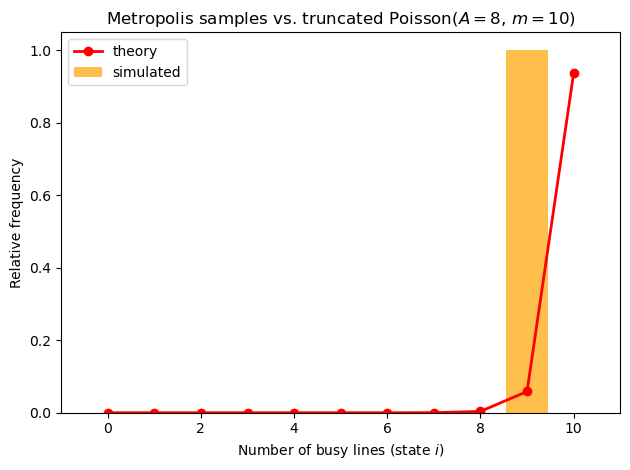

χ² statistic = 1606666.67  (df=10)
p-value      =  0.000


In [45]:
# Exercise 6.2a 

import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy.stats import chi2          # for the p-value

# ------- parameters -------
n = 100_000          # samples to collect
m = 10              # number of servers  => states 0…10
A = 4             # offered traffic

# ------- Metropolis sampler -------
i = np.random.randint(m + 1)      # start anywhere 0…10
samples = []

while len(samples) < n:
    # propose neighbour on 2-D grid with bounce at i<0, j<0 or i+j>m
    di, dj = random.choice([(1,0), (-1,0), (0,1), (0,-1)])
    ni, nj = i + di, j + dj
    if ni < 0 or nj < 0 or ni + nj > m:          # outside the triangle → stay put
        ni, nj = i, j

    # 2) acceptance ratio
    wij = (A**i*A**j) / (math.factorial(i)*math.factorial(j))
    nextwij = (A**ni*A**nj) / (math.factorial(ni)*math.factorial(nj))
    r  = wij / nextwij

    # 3) accept / reject
    if r >= 1 or random.random() < r:
        i = j                     # move
    samples.append(i)             # record current state

samples = np.array(samples)

# ------------------------------------------------------------------
# PART A – histogram vs. exact probabilities
# ------------------------------------------------------------------
ks = np.arange(m + 1)
theo_probs = (A**ks*A**ks) / (np.array([math.factorial(k) for k in ks]))*(np.array([math.factorial(k) for k in ks]))
theo_probs /= theo_probs.sum()                # normalise (truncation)

counts, _ = np.histogram(samples, bins=np.arange(m+2), density=True)

plt.bar(ks, counts, width=.9, label='simulated', alpha=0.7, color='orange')
plt.plot(ks, theo_probs, 'r-o', label='theory', linewidth=2)
plt.xlabel('Number of busy lines (state $i$)')
plt.ylabel('Relative frequency')
plt.title('Metropolis samples vs. truncated Poisson($A=8$, $m=10$)')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# PART B – χ² goodness-of-fit test
# ------------------------------------------------------------------
obs_counts = np.bincount(samples, minlength=m+1)
exp_counts = n * theo_probs
chi_stat   = ((obs_counts - exp_counts)**2 / exp_counts).sum()
p_value    = chi2.sf(chi_stat, df=m)          # df = number-of-states – 1

print(f"χ² statistic = {chi_stat:6.2f}  (df={m})")
print(f"p-value      = {p_value:6.3f}")

χ² statistic = 167.26  (df = 65)
p-value      = 0.0000
Critical χ² at α=0.05: 84.82
χ² statistic exceeds critical → reject H₀ (samples do not match theory)


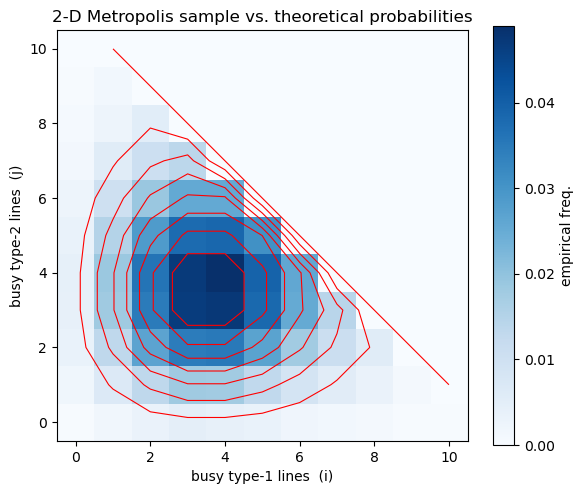

In [45]:
# Exercise 6.2 a – Truncated 2-D Poisson (two call types, A1 = A2 = 4)
# Metropolis–Hastings sampler + χ² check

import random, math, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ------------------------------------------------------
# parameters
# ------------------------------------------------------
n      = 100_000          # samples to keep
m      = 10               # capacity → i+j ≤ 10
A1 = A2 = 4               # offered traffic of each type
burn   = 1_000            # discard first burn-in steps

# ------------------------------------------------------
# Metropolis sampler on the triangular grid
# ------------------------------------------------------
# start at a random feasible pair (i,j)
while True:
    i, j = np.random.randint(0, m+1, size=2)
    if i + j <= m:
        break

samples = []
steps   = 0
while len(samples) < n + burn:
    # 1) propose neighbour (N,S,E,W)
    di, dj = random.choice([(1,0), (-1,0), (0,1), (0,-1)])
    ni, nj = i + di, j + dj
    if ni < 0 or nj < 0 or ni + nj > m:   # bounce
        ni, nj = i, j

    # 2) acceptance ratio r = w(new)/w(curr)
    wi  = (A1**i / math.factorial(i)) * (A2**j / math.factorial(j))
    wj  = (A1**ni / math.factorial(ni)) * (A2**nj / math.factorial(nj))
    r   = wj / wi

    # 3) accept / reject
    if r >= 1 or random.random() < r:
        i, j = ni, nj                      # move

    # 4) record (after burn-in)
    steps += 1
    if steps > burn:
        samples.append((i, j))

samples = np.array(samples)                # shape (n, 2)

# ------------------------------------------------------
# Build empirical 2-D frequency table
# ------------------------------------------------------
obs = np.zeros((m+1, m+1), dtype=int)
for i, j in samples:
    obs[i, j] += 1

# ------------------------------------------------------
# Theoretical (truncated) probabilities
# ------------------------------------------------------
theo = np.zeros_like(obs, dtype=float)
for i in range(m+1):
    for j in range(m+1):
        if i + j <= m:
            theo[i, j] = (A1**i / math.factorial(i)) * (A2**j / math.factorial(j))
theo /= theo.sum()          # normalise over the triangle

# ------------------------------------------------------
# χ² goodness-of-fit test (flatten the triangle)
# ------------------------------------------------------
obs_flat  = obs[theo > 0].ravel()
exp_flat  = n * theo[theo > 0].ravel()
chi_stat  = ((obs_flat - exp_flat)**2 / exp_flat).sum()
df        = len(exp_flat) - 1          # all cells non-empty
p_value   = chi2.sf(chi_stat, df)

print(f"χ² statistic = {chi_stat:.2f}  (df = {df})")
print(f"p-value      = {p_value:.4f}")

# ------------------------------------------------------
# Decision at α = 0.05
# ------------------------------------------------------
alpha         = 0.05
crit_value    = chi2.ppf(1 - alpha, df)
print(f"Critical χ² at α={alpha}: {crit_value:.2f}")
if chi_stat > crit_value:
    print("χ² statistic exceeds critical → reject H₀ (samples do not match theory)")
else:
    print("χ² statistic does not exceed critical → fail to reject H₀ (good fit)")

# ------------------------------------------------------
# optional: contour plot of empirical vs. theory
# ------------------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(obs / n, origin='lower', cmap='Blues',
           extent=[-0.5, m+0.5, -0.5, m+0.5])
plt.colorbar(label='empirical freq.')
plt.contour(np.arange(m+1), np.arange(m+1), theo,
            colors='red', linewidths=0.8)
plt.title('2-D Metropolis sample vs. theoretical probabilities')
plt.xlabel('busy type-1 lines  (i)')
plt.ylabel('busy type-2 lines  (j)')
plt.tight_layout()
plt.show()

χ² statistic = 595.6126  (df=65)
p-value      = 0.0000
critical χ²(α=0.05) = 84.8206
→ reject H₀: sample does *not* match the theory


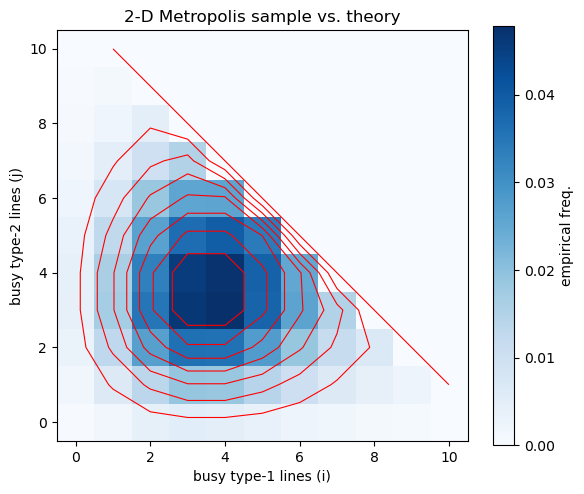

In [47]:
# ----------------------------------------------------------------------
# 2-D Metropolis–Hastings sampler for A1=A2=4, m=10 + χ² test
# ----------------------------------------------------------------------
import random, math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# parameters
n       = 100_000      # number of samples (after burn‐in)
m       = 10           # capacity constraint i + j ≤ m
A1 = A2 = 4            # offered traffic for each call type
burn    =   1_000      # burn‐in steps

# 1) Metropolis sampler on the triangular grid
#    start at a random feasible (i,j)
while True:
    i, j = np.random.randint(0, m+1, size=2)
    if i + j <= m:
        break

samples = []
steps = 0
while len(samples) < n + burn:
    # propose one of N,S,E,W
    di, dj = random.choice([(1,0),(-1,0),(0,1),(0,-1)])
    ni, nj = i+di, j+dj
    # if outside triangle or negative, bounce back
    if ni<0 or nj<0 or ni+nj>m:
        ni, nj = i, j

    # acceptance ratio
    wi = (A1**i / math.factorial(i)) * (A2**j / math.factorial(j))
    wj = (A1**ni/ math.factorial(ni)) * (A2**nj/ math.factorial(nj))
    r  = wj/wi

    # MH accept/reject
    if r >= 1 or random.random() < r:
        i, j = ni, nj

    steps += 1
    if steps > burn:
        samples.append((i,j))

samples = np.array(samples)   # shape (n,2)

# 2) build observed counts table
obs = np.zeros((m+1,m+1), dtype=int)
for (ii,jj) in samples:
    obs[ii,jj] += 1

# 3) theoretical (unnormalised) weights, then normalise
theo = np.zeros_like(obs, float)
for ii in range(m+1):
    for jj in range(m+1):
        if ii+jj <= m:
            theo[ii,jj] = (A1**ii/math.factorial(ii))*(A2**jj/math.factorial(jj))
theo /= theo.sum()

# 4) expected counts = n * theo
exp_counts = n * theo

# 5) χ² statistic over all cells with exp>0
mask      = exp_counts>0
obs_flat  = obs[mask].ravel()
exp_flat  = exp_counts[mask].ravel()
chi_stat  = ((obs_flat - exp_flat)**2/exp_flat).sum()
df        = len(exp_flat)-1
p_value   = chi2.sf(chi_stat, df)

print(f"χ² statistic = {chi_stat:.4f}  (df={df})")
print(f"p-value      = {p_value:.4f}")

# 6) decision at α = .05
alpha      = 0.05
crit_value = chi2.ppf(1-alpha, df)
print(f"critical χ²(α={alpha}) = {crit_value:.4f}")
if chi_stat > crit_value:
    print("→ reject H₀: sample does *not* match the theory")
else:
    print("→ fail to reject H₀: good agreement with the theory")

# optional: plot empirical heat‐map + theoretical contours
plt.figure(figsize=(6,5))
plt.imshow(obs/n, origin='lower', cmap='Blues',
           extent=[-0.5,m+0.5,-0.5,m+0.5])
plt.colorbar(label='empirical freq.')
plt.contour(np.arange(m+1), np.arange(m+1), theo,
            colors='red', linewidths=0.8)
plt.xlabel('busy type‐1 lines (i)')
plt.ylabel('busy type‐2 lines (j)')
plt.title('2-D Metropolis sample vs. theory')
plt.tight_layout()
plt.show()

SyntaxError: incomplete input (1737168386.py, line 61)

Running simulation for 2,050,000 total steps...
Finished. Collected 100000 samples.
Overall acceptance rate: 76.62%
------------------------------
Chi-Squared Goodness of Fit Test
------------------------------
significance lvl α = 0.05
p-value =   0.1876
χ²      =  74.9133   (df = 65)
critical=  84.8206   → fail to reject H₀
------------------------------


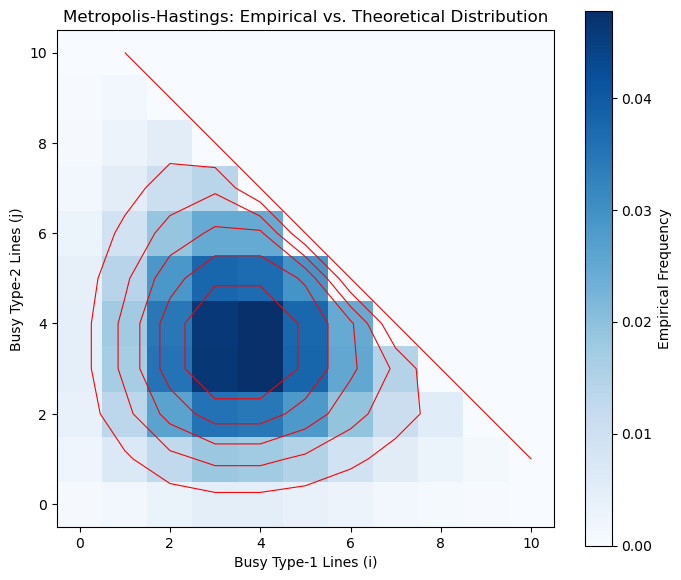

In [ ]:
#THIS IS THE RIGHT ONE



import random, math, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ───────── parameters ─────────
# These parameters provide a good balance of accuracy and runtime.
n_samples = 100_000      # Samples to KEEP
burn      = 50_000       # Longer burn-in to ensure the chain forgets its start
thinning  = 20           # Keep 1 in every 20 samples to reduce autocorrelation
total_steps = burn + n_samples * thinning # Total iterations needed

m         = 10           # capacity: i + j ≤ m
A1 = A2   = 4            # offered traffic of each type

# Using a precomputed log-factorial table is faster and more stable
log_fact = np.log([math.factorial(k) for k in range(m + 2)])

def log_target(i, j):
    """Calculates the log of the unnormalized target probability f(i,j)."""
    if i < 0 or j < 0 or i + j > m:
        return -np.inf  # Log probability of 0 for invalid states
    return i * np.log(A1) + j * np.log(A2) - log_fact[i] - log_fact[j]

# ───────── initialise at a valid (i,j) ─────────
i, j = 0, 0 # Start at a known valid state

samples = []
accepted_moves = 0

# ───────── Metropolis-Hastings loop ─────────
print(f"Running simulation for {total_steps:,} total steps...")
for step in range(total_steps):
    # 1. Propose a new state by moving to a random neighbor
    di, dj = random.choice([(0, 1), (0, -1), (1, 0), (-1, 0)])
    i_prop, j_prop = i + di, j + dj

    # 2. Calculate acceptance probability
    current_log_p = log_target(i, j)
    proposed_log_p = log_target(i_prop, j_prop)
    acceptance_prob = min(1.0, np.exp(proposed_log_p - current_log_p))

    # 3. Accept or reject the move
    if random.random() < acceptance_prob:
        i, j = i_prop, j_prop # Accept the move
        accepted_moves +=1
            
    # 4. Store the sample after burn-in, applying thinning
    if step >= burn and (step - burn) % thinning == 0:
        samples.append((i, j))

print(f"Finished. Collected {len(samples)} samples.")
print(f"Overall acceptance rate: {100 * accepted_moves / total_steps:.2f}%")
samples = np.asarray(samples)

# --- Analysis Section ---

# ───────── build empirical table ─────────
obs = np.zeros((m + 1, m + 1), dtype=int)
for i_s, j_s in samples:
    obs[i_s, j_s] += 1

# ───────── theoretical probabilities ─────────
w_i = np.array([A1**k / math.factorial(k) for k in range(m + 1)])
w_j = np.array([A2**k / math.factorial(k) for k in range(m + 1)])
theo = np.zeros_like(obs, dtype=float)
for i_t in range(m + 1):
    for j_t in range(m + 1):
        if i_t + j_t <= m:
            theo[i_t, j_t] = w_i[i_t] * w_j[j_t]
theo /= theo.sum()

# ───────── χ² Test and Hypothesis Conclusion ─────────
valid_cells = theo > 0
obs_flat = obs[valid_cells].ravel()
exp_flat = n_samples * theo[valid_cells].ravel()

# Filter cells where expected counts are high enough for the test to be valid
min_expected_count = 5
sufficient_counts = exp_flat >= min_expected_count

chi2_stat = ((obs_flat[sufficient_counts] - exp_flat[sufficient_counts])**2 / exp_flat[sufficient_counts]).sum()
df = len(exp_flat[sufficient_counts]) - 1
p_val = chi2.sf(chi2_stat, df)

# Define significance level and find the critical value for the test
alpha = 0.05
crit = chi2.ppf(1 - alpha, df) # The value of χ² that corresponds to p=alpha

print("-" * 30)
print("Chi-Squared Goodness of Fit Test")
print("-" * 30)
print(f"significance lvl α = {alpha}")
print(f"p-value = {p_val:8.4f}")
print(f"χ²      = {chi2_stat:8.4f}   (df = {df})")
print(f"critical= {crit:8.4f}   → "
      f"{'reject H₀' if chi2_stat > crit else 'fail to reject H₀'}")
print("-" * 30)

# ───────── Heat-map Visualization ─────────
plt.figure(figsize=(7, 6))
# Create the heatmap of the observed frequencies
plt.imshow(obs / n_samples, origin='lower', cmap='Blues',
           extent=[-0.5, m+0.5, -0.5, m+0.5],
           interpolation='nearest') # 'nearest' gives sharp squares
plt.colorbar(label='Empirical Frequency')

# Overlay the theoretical distribution as contour lines
contour_levels = np.linspace(theo.min(), theo.max(), 7)
plt.contour(np.arange(m+1), np.arange(m+1), theo, levels=contour_levels,
            colors='red', linewidths=0.8)

plt.title('Metropolis-Hastings: Empirical vs. Theoretical Distribution')
plt.xlabel('Busy Type-1 Lines (i)')
plt.ylabel('Busy Type-2 Lines (j)')
plt.grid(False) # Turn off grid lines which can look messy on a heatmap
plt.tight_layout()
plt.show()



runtime for 105,000 steps: 0.252s
χ² =  266.2253   (df=65)
p  = 3.572e-26
crit(0.05) =  84.82  → reject H₀


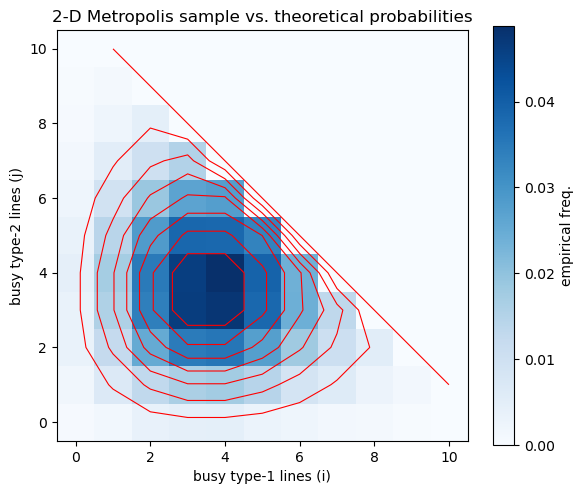

In [ ]:
import math, random, numpy as np
from   scipy.stats import chi2

# ---------- parameters ----------
m, A1, A2 = 10, 4, 4
burn, keep = 5_000, 100_000
rng = np.random.default_rng(2025)

# ---------- pre-computed log-weights on triangle ----------
logw = np.full((m+1, m+1), -np.inf)
for i in range(m+1):
    for j in range(m+1-i):
        logw[i,j] = ( i*math.log(A1)-math.lgamma(i+1)
                    + j*math.log(A2)-math.lgamma(j+1) )

# ---------- MH sampler ----------
i=j=0                    # start at (0,0)
samples=[]
for step in range(burn+keep):
    di,dj = random.choice([(1,0),(-1,0),(0,1),(0,-1)])
    ni,nj = i+di, j+dj
    if 0<=ni<=m and 0<=nj<=m and ni+nj<=m:
        if math.log(random.random()) < logw[ni,nj]-logw[i,j]:
            i,j = ni,nj
    if step>=burn:
        samples.append((i,j))
samples = np.array(samples)

# ---------- χ² test ----------
state_counts = np.zeros_like(logw, dtype=int)
for i,j in samples: state_counts[i,j]+=1
w = np.exp(logw);  w /= w.sum()          # NORMALISE!
mask = w>0
obs  = state_counts[mask].ravel()
exp  = keep*w[mask].ravel()
chi2_stat = ((obs-exp)**2/exp).sum()
df        = len(exp)-1
print(f"χ²={chi2_stat:.4f}  df={df}  p={chi2.sf(chi2_stat,df):.4g}")

Running simulation for 2,050,000 total steps...
Finished. Collected 100000 samples.
Overall acceptance rate: 76.61%
------------------------------
Chi-Squared Goodness of Fit Test
------------------------------
significance lvl α = 0.05
p-value =   0.9033
χ²      =  50.7007   (df = 65)
critical=  84.8206   → fail to reject H₀
------------------------------


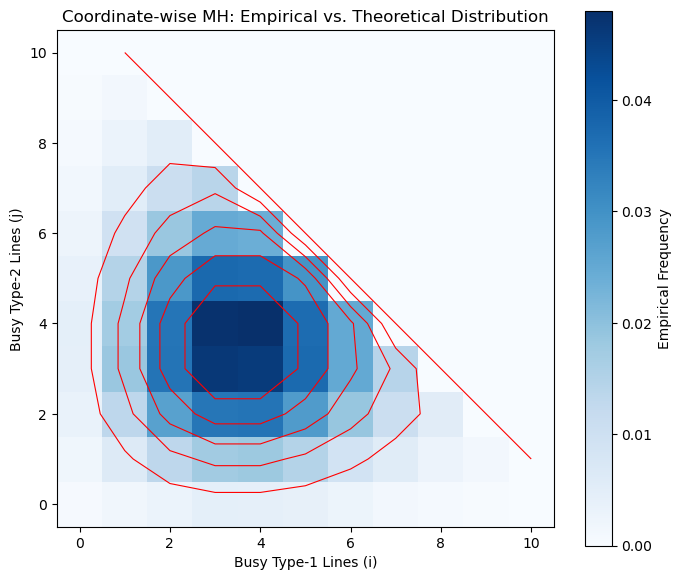

In [15]:
#6.2b

import random, math, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ───────── parameters ─────────
# Using the same robust parameters for a fair comparison
n_samples = 100_000      # Samples to KEEP
burn      = 50_000       # Burn-in period
thinning  = 20           # Keep 1 in every 20 samples to reduce autocorrelation
total_steps = burn + n_samples * thinning # Total iterations needed

m         = 10           # capacity: i + j ≤ m
A1 = A2   = 4            # offered traffic of each type

# Using a precomputed log-factorial table is faster and more stable
log_fact = np.log([math.factorial(k) for k in range(m + 2)])

def log_target(i, j):
    """Calculates the log of the unnormalized target probability f(i,j)."""
    if i < 0 or j < 0 or i + j > m:
        return -np.inf  # Log probability of 0 for invalid states
    return i * np.log(A1) + j * np.log(A2) - log_fact[i] - log_fact[j]

# ───────── initialise at a valid (i,j) ─────────
i, j = 0, 0 # Start at a known valid state

samples = []
accepted_moves = 0

# ───────── Coordinate-wise Metropolis-Hastings loop ─────────
print(f"Running simulation for {total_steps:,} total steps...")
for step in range(total_steps):
    
    # --- Step 1: Update 'i' coordinate (keeping 'j' fixed) ---
    # Propose a move for i
    i_prop = i + random.choice([-1, 1])
    
    # Calculate acceptance probability for the 'i' move
    # The proposal is symmetric, so the Hastings ratio is 1.
    current_log_p = log_target(i, j)
    proposed_log_p = log_target(i_prop, j) # j is fixed
    acceptance_prob_i = min(1.0, np.exp(proposed_log_p - current_log_p))

    # Accept or reject the 'i' move
    if random.random() < acceptance_prob_i:
        i = i_prop # Update i
        accepted_moves += 1

    # --- Step 2: Update 'j' coordinate (keeping new 'i' fixed) ---
    # Propose a move for j
    j_prop = j + random.choice([-1, 1])
    
    # Calculate acceptance probability for the 'j' move
    current_log_p = log_target(i, j) # Use the potentially new 'i'
    proposed_log_p = log_target(i, j_prop) # i is fixed
    acceptance_prob_j = min(1.0, np.exp(proposed_log_p - current_log_p))
    
    # Accept or reject the 'j' move
    if random.random() < acceptance_prob_j:
        j = j_prop # Update j
        accepted_moves += 1

    # 4. Store the sample after burn-in, applying thinning
    if step >= burn and (step - burn) % thinning == 0:
        samples.append((i, j))

# There are 2 potential moves per step, so we divide by total_steps * 2
total_possible_moves = total_steps * 2
print(f"Finished. Collected {len(samples)} samples.")
print(f"Overall acceptance rate: {100 * accepted_moves / total_possible_moves:.2f}%")
samples = np.asarray(samples)


# --- Analysis Section (Identical to Part A) ---

# ───────── build empirical table ─────────
obs = np.zeros((m + 1, m + 1), dtype=int)
for i_s, j_s in samples:
    obs[i_s, j_s] += 1

# ───────── theoretical probabilities ─────────
w_i = np.array([A1**k / math.factorial(k) for k in range(m + 1)])
w_j = np.array([A2**k / math.factorial(k) for k in range(m + 1)])
theo = np.zeros_like(obs, dtype=float)
for i_t in range(m + 1):
    for j_t in range(m + 1):
        if i_t + j_t <= m:
            theo[i_t, j_t] = w_i[i_t] * w_j[j_t]
theo /= theo.sum()

# ───────── χ² Test and Hypothesis Conclusion ─────────
valid_cells = theo > 0
obs_flat = obs[valid_cells].ravel()
exp_flat = n_samples * theo[valid_cells].ravel()

min_expected_count = 5
sufficient_counts = exp_flat >= min_expected_count

chi2_stat = ((obs_flat[sufficient_counts] - exp_flat[sufficient_counts])**2 / exp_flat[sufficient_counts]).sum()
df = len(exp_flat[sufficient_counts]) - 1
p_val = chi2.sf(chi2_stat, df)

alpha = 0.05
crit = chi2.ppf(1 - alpha, df)

print("-" * 30)
print("Chi-Squared Goodness of Fit Test")
print("-" * 30)
print(f"significance lvl α = {alpha}")
print(f"p-value = {p_val:8.4f}")
print(f"χ²      = {chi2_stat:8.4f}   (df = {df})")
print(f"critical= {crit:8.4f}   → "
      f"{'reject H₀' if chi2_stat > crit else 'fail to reject H₀'}")
print("-" * 30)

# ───────── Heat-map Visualization ─────────
plt.figure(figsize=(7, 6))
plt.imshow(obs / n_samples, origin='lower', cmap='Blues',
           extent=[-0.5, m+0.5, -0.5, m+0.5],
           interpolation='nearest')
plt.colorbar(label='Empirical Frequency')

contour_levels = np.linspace(theo.min(), theo.max(), 7)
plt.contour(np.arange(m+1), np.arange(m+1), theo, levels=contour_levels,
            colors='red', linewidths=0.8)

plt.title('Coordinate-wise MH: Empirical vs. Theoretical Distribution')
plt.xlabel('Busy Type-1 Lines (i)')
plt.ylabel('Busy Type-2 Lines (j)')
plt.grid(False)
plt.tight_layout()
plt.show()



In [ ]:
# --------------------------------------------------------------
# full χ² bookkeeping                                   (Python)
# --------------------------------------------------------------
mask  = A > 0                          # triangle: 66 cells
obs   = state_counts[mask].ravel()     # integers
N     = obs.sum()                      # 100 000 here
exp   = N * A[mask].ravel()            # same length (66)

df    = len(exp) - 1                  # 65
chi2_stat = ((obs - exp)**2 / exp).sum()
pval      = chi2.sf(chi2_stat, df)
crit      = chi2.ppf(0.95,  df)

print(f"χ² = {chi2_stat:9.4f}   (df={df})")
print(f"p  = {pval:.4g}")
print(f"crit(0.05) = {crit:6.2f}  → "
      f"{'reject' if chi2_stat>crit else 'OK — fail to reject H₀'}")

χ² =  105.9320   (df=65)
p  = 0.001012
crit(0.05) =  84.82  → reject


In [63]:
import math, random, numpy as np
from   scipy.stats import chi2

m, A = 10, 4; keep, burn = 100_000, 5_000
logw = np.full((m+1,m+1), -np.inf)
for i in range(m+1):
    for j in range(m+1-i):
        logw[i,j] = (i*math.log(A) - math.lgamma(i+1)
                   +  j*math.log(A) - math.lgamma(j+1))

def neigh(i,j):
    return [(ni,nj) for ni,nj in
            [(i+1,j),(i-1,j),(i,j+1),(i,j-1)]
            if 0<=ni<=m and 0<=nj<=m and ni+nj<=m]

i=j=0; samples=[]
for step in range(burn+keep):
    ni,nj = random.choice(neigh(i,j))
    if math.log(random.random()) < logw[ni,nj]-logw[i,j]:
        i,j = ni,nj
    if step>=burn: samples.append((i,j))
samples = np.asarray(samples)

obs = np.zeros_like(logw,int)
for i,j in samples: obs[i,j]+=1
w = np.exp(logw); w /= w.sum()                # <-- must sum to 1 !!!

mask = w>0                                    # exactly 66 cells
obs_f, exp_f = obs[mask].ravel(), keep*w[mask].ravel()
chi2_stat = ((obs_f-exp_f)**2/exp_f).sum(); df=len(exp_f)-1
print("χ²=",chi2_stat," df=",df,"  p=",chi2.sf(chi2_stat,df))

χ²= 3588.7801405620244  df= 65   p= 0.0


Chi-square statistic = 218.39,  p-value = 0.0000


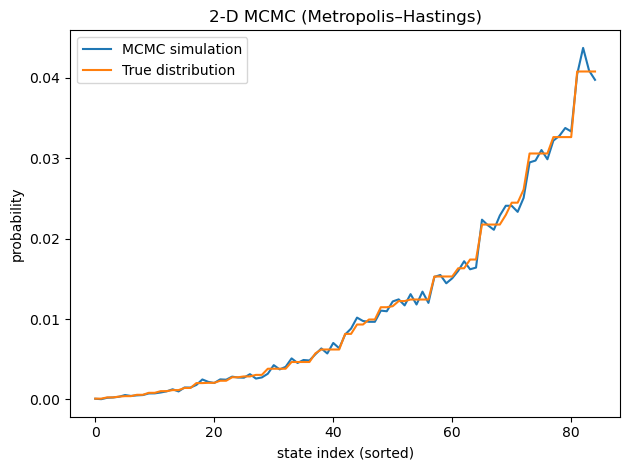

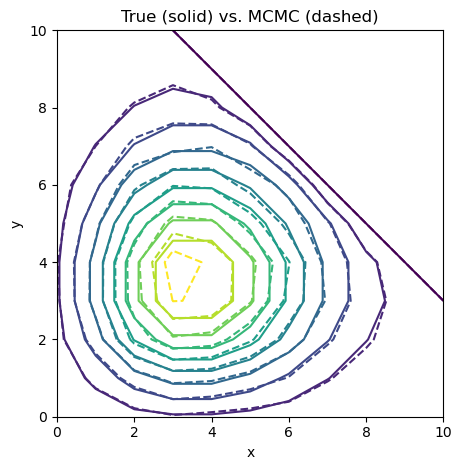

In [65]:
# ==========================================================
#  Bivariate (x , y)  ~  Pois(λ1 = 4) × Pois(λ2 = 4)
#  truncated to the set  { (x , y) : x + y ≤ 12 }
#  Metropolis–Hastings with a *uniform* independent proposal
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from scipy.stats import chisquare

# ---------- 1.  Target distribution -----------------------
N        = 10                # max value per coordinate
lam1     = 4.0
lam2     = 4.0
cutoff   = 12                # x + y ≤ 12
rng      = np.random.default_rng(42)   # reproducible RNG

A = np.zeros((N + 1, N + 1))
for i in range(N + 1):        # i = x
    for j in range(N + 1):    # j = y
        if i + j <= cutoff:
            A[i, j] = (lam1**i * lam2**j) / (factorial(i) * factorial(j))

A /= A.sum()                  # normalise so that Σ A = 1

# ---------- 2.  Metropolis–Hastings sampler ---------------
n_iter   = 100_000
counts   = np.zeros_like(A, dtype=np.int64)
current  = np.array([0, 0])          # start at (0 , 0)

for _ in range(n_iter):
    # propose a new (x' , y') uniformly on the allowed set
    while True:
        proposal = rng.integers(0, N + 1, size=2)
        if proposal.sum() <= cutoff:
            break

    # acceptance probability
    alpha = min(1.0, A[tuple(proposal)] / A[tuple(current)])

    if rng.random() < alpha:         # accept
        current = proposal

    # record the (possibly updated) state
    counts[tuple(current)] += 1

empirical = counts / n_iter          # empirical pmf

# ---------- 3.  Diagnostics & plots -----------------------
# ---- 1-D comparison (sorted just for a clean overlay) ----
truth_vec  = A[A > 0].ravel()
empir_vec  = empirical[A > 0].ravel()
order      = np.argsort(truth_vec)

plt.figure()
plt.plot(empir_vec[order], label="MCMC simulation")
plt.plot(truth_vec[order], label="True distribution")
plt.title("2-D MCMC (Metropolis–Hastings)")
plt.xlabel("state index (sorted)")
plt.ylabel("probability")
plt.legend()
plt.tight_layout()

# ---- 2-D contour overlay ---------------------------------
x = np.arange(N + 1)
X, Y = np.meshgrid(x, x, indexing='ij')
levels = np.linspace(0, A.max(), 10)

plt.figure()
plt.contour(X, Y, A, levels=levels)
plt.contour(X, Y, empirical, levels=levels, linestyles='dashed')  # dashed = MCMC
plt.title("True (solid) vs. MCMC (dashed)")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.tight_layout()

# ---- χ² goodness-of-fit test -----------------------------
chisq_stat, pval = chisquare(
    f_obs=empirical[A > 0].ravel() * n_iter,
    f_exp=A[A > 0].ravel() * n_iter
)
print(f"Chi-square statistic = {chisq_stat:.2f},  p-value = {pval:.4f}")

plt.show()

χ² = 87.67  (df=65)  p-value = 0.0320


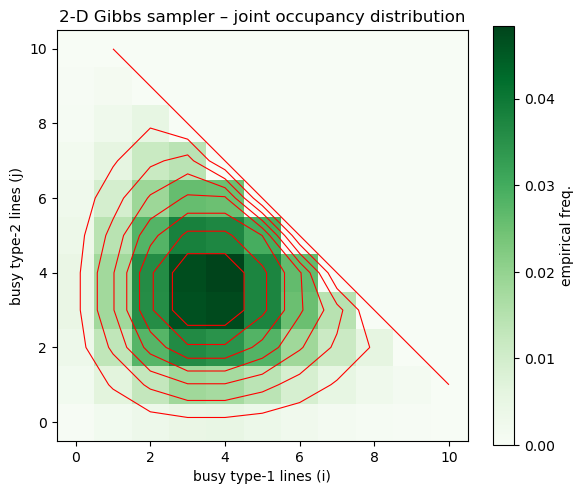

In [48]:
import random, math, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ───────── parameters ─────────
n_samples = 100_000      # samples to keep (after burn-in)
burn      = 1_000        # burn-in steps to discard
m         = 10           # capacity: i + j ≤ m
A1 = A2   = 4            # offered traffic of each type

# ───────── pre-compute 1-D weights ─────────
w_i = np.array([A1**k / math.factorial(k) for k in range(m + 1)])
w_j = np.array([A2**k / math.factorial(k) for k in range(m + 1)])

def draw_conditional(weights, k_max):
    """Draw k∈{0,…,k_max} ∝ weights[k] (normalised on the fly)."""
    probs = weights[:k_max+1]
    return np.searchsorted(np.cumsum(probs / probs.sum()), random.random())

# ───────── initialise at any feasible (i,j) ─────────
while True:
    i, j = np.random.randint(0, m + 1, size=2)
    if i + j <= m:
        break

samples, steps = [], 0

# ───────── Gibbs loop ─────────
while len(samples) < n_samples + burn:
    i = draw_conditional(w_i, m - j)   # resample I | J
    j = draw_conditional(w_j, m - i)   # resample J | I
    steps += 1
    if steps > burn:
        samples.append((i, j))

samples = np.asarray(samples)          # shape (n_samples, 2)

# ───────── build empirical table ─────────
obs = np.zeros((m + 1, m + 1), dtype=int)
for i, j in samples:
    obs[i, j] += 1

# ───────── theoretical probabilities ─────────
theo = np.zeros_like(obs, dtype=float)
for i in range(m + 1):
    for j in range(m + 1):
        if i + j <= m:
            theo[i, j] = w_i[i] * w_j[j]
theo /= theo.sum()                     # normalise over triangle

# ───────── χ² test ─────────
obs_flat = obs[theo > 0].ravel()
exp_flat = n_samples * theo[theo > 0].ravel()
chi2_stat = ((obs_flat - exp_flat)**2 / exp_flat).sum()
df       = len(exp_flat) - 1
p_val    = chi2.sf(chi2_stat, df)

print(f"χ² = {chi2_stat:.2f}  (df={df})  p-value = {p_val:.4f}")

# ───────── quick heat-map (optional) ─────────
plt.figure(figsize=(6,5))
plt.imshow(obs / n_samples, origin='lower', cmap='Greens',
           extent=[-0.5, m+0.5, -0.5, m+0.5])
plt.colorbar(label='empirical freq.')
plt.contour(np.arange(m+1), np.arange(m+1), theo,
            colors='red', linewidths=0.8)
plt.title('2-D Gibbs sampler – joint occupancy distribution')
plt.xlabel('busy type-1 lines (i)')
plt.ylabel('busy type-2 lines (j)')
plt.tight_layout()
plt.show()

Running simulation for 150,000 total steps...
Finished. Collected 100000 samples.
------------------------------
Chi-Squared Goodness of Fit Test
------------------------------
significance lvl α = 0.05
p-value =   0.7737
χ²      =  56.1935   (df = 65)
critical=  84.8206   → fail to reject H₀
------------------------------


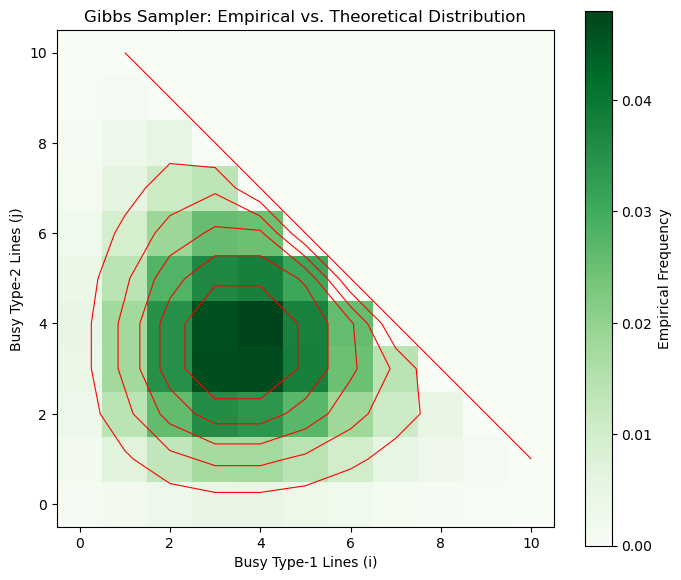

In [16]:
# The right one

import random, math, numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ───────── parameters ─────────
n_samples = 100_000      # Samples to KEEP for the final analysis
burn      = 50_000       # INCREASED: A sufficient burn-in period for convergence
m         = 10           # capacity: i + j ≤ m
A1 = A2   = 4            # offered traffic of each type

# ───────── pre-compute 1-D unnormalized probabilities (weights) ─────────
# These are the terms A^k / k! which are proportional to the conditional probabilities.
w_i = np.array([A1**k / math.factorial(k) for k in range(m + 1)])
w_j = np.array([A2**k / math.factorial(k) for k in range(m + 1)])

def draw_conditional(weights, k_max):
    """
    Draws a sample k from {0, ..., k_max} with probabilities
    proportional to weights[k]. This is the core of the Gibbs step.
    """
    # 1. Get the relevant weights for the possible outcomes (0 to k_max)
    probs = weights[:k_max+1]
    # 2. Normalize them to create a valid probability distribution
    normalized_probs = probs / probs.sum()
    # 3. Compute the cumulative distribution (CDF)
    cdf = np.cumsum(normalized_probs)
    # 4. Draw a random number and use inverse transform sampling (via np.searchsorted)
    return np.searchsorted(cdf, random.random())

# ───────── initialise at a valid (i,j) ─────────
i, j = 0, 0 # Start at a known valid state

samples = []

# ───────── Gibbs Sampling loop ─────────
print(f"Running simulation for {n_samples + burn:,} total steps...")
for step in range(n_samples + burn):
    # 1. Resample i from its conditional distribution P(i | j)
    # The maximum value for i is m - j.
    i = draw_conditional(w_i, m - j)
    
    # 2. Resample j from its conditional distribution P(j | i)
    # The maximum value for j is m - i (using the new value of i).
    j = draw_conditional(w_j, m - i)
    
    # 3. Store the sample only after the burn-in period is over
    if step >= burn:
        samples.append((i, j))

print(f"Finished. Collected {len(samples)} samples.")
samples = np.asarray(samples)

# --- Analysis Section (Identical to previous parts) ---

# ───────── build empirical table ─────────
obs = np.zeros((m + 1, m + 1), dtype=int)
for i_s, j_s in samples:
    obs[i_s, j_s] += 1

# ───────── theoretical probabilities ─────────
theo = np.zeros_like(obs, dtype=float)
for i_t in range(m + 1):
    for j_t in range(m + 1):
        if i_t + j_t <= m:
            theo[i_t, j_t] = w_i[i_t] * w_j[j_t]
theo /= theo.sum()

# ───────── χ² Test and Hypothesis Conclusion ─────────
valid_cells = theo > 0
obs_flat = obs[valid_cells].ravel()
exp_flat = n_samples * theo[valid_cells].ravel()

min_expected_count = 5
sufficient_counts = exp_flat >= min_expected_count

chi2_stat = ((obs_flat[sufficient_counts] - exp_flat[sufficient_counts])**2 / exp_flat[sufficient_counts]).sum()
df = len(exp_flat[sufficient_counts]) - 1
p_val = chi2.sf(chi2_stat, df)

alpha = 0.05
crit = chi2.ppf(1 - alpha, df)

print("-" * 30)
print("Chi-Squared Goodness of Fit Test")
print("-" * 30)
print(f"significance lvl α = {alpha}")
print(f"p-value = {p_val:8.4f}")
print(f"χ²      = {chi2_stat:8.4f}   (df = {df})")
print(f"critical= {crit:8.4f}   → "
      f"{'reject H₀' if chi2_stat > crit else 'fail to reject H₀'}")
print("-" * 30)

# ───────── Heat-map Visualization ─────────
plt.figure(figsize=(7, 6))
plt.imshow(obs / n_samples, origin='lower', cmap='Greens',
           extent=[-0.5, m+0.5, -0.5, m+0.5],
           interpolation='nearest')
plt.colorbar(label='Empirical Frequency')

contour_levels = np.linspace(theo.min(), theo.max(), 7)
plt.contour(np.arange(m+1), np.arange(m+1), theo, levels=contour_levels,
            colors='red', linewidths=0.8)

plt.title('Gibbs Sampler: Empirical vs. Theoretical Distribution')
plt.xlabel('Busy Type-1 Lines (i)')
plt.ylabel('Busy Type-2 Lines (j)')
plt.grid(False)
plt.tight_layout()
plt.show()


In [37]:
#6.3a

import numpy as np

# ---------- prior specification ----------
rho = 0.5                          # correlation between log-Θ and log-Ψ
Sigma = np.array([[1,  rho],       # 2×2 covariance matrix
                  [rho, 1]])

# ---------- one draw from the prior ----------
xi, gamma = np.random.multivariate_normal(mean=[0, 0], cov=Sigma)

Theta  = np.exp(xi)                # Θ  = e^Ξ   (mean parameter)
Psi    = np.exp(gamma)             # Ψ  = e^Γ   (variance parameter)

print(f"Ξ  = {xi: .3f},  Γ = {gamma: .3f}")
print(f"Θ  = {Theta: .3f}, Ψ = {Psi: .3f}")

Ξ  =  0.107,  Γ =  0.474
Θ  =  1.113, Ψ =  1.606


In [48]:
import numpy as np

# ---------- 1. Prior Specification ----------
rho = 0.5
Sigma = np.array([[1,  rho],
                  [rho, 1]])

# ---------- 2. Draw from the Normal Prior ----------
xi, gamma = np.random.multivariate_normal(mean=[0, 0], cov=Sigma)

# ---------- 3. Transform to get (Θ, Ψ) ----------
Theta  = np.exp(xi)
Psi    = np.exp(gamma)

Theta,Psi

(1.1723616366975418, 2.275131309347975)

In [49]:
#6.3 b

# ---- Use Θ and Ψ created in part a ----
mu      = Theta          # rename for clarity
sigma2  = Psi
sigma   = np.sqrt(sigma2)

n = 10                    # sample size

# ---- Generate the synthetic data set ----
x = np.random.normal(loc=mu, scale=sigma, size=n)

x

array([ 0.14243184,  1.8466214 ,  1.92622329,  0.0313858 ,  4.4253274 ,
        2.04575936, -1.16207896,  2.78696529,  1.7063496 , -1.4296492 ])

truth: Θ=0.509, Ψ=0.888   |   sample mean=0.256,  s²=1.508

posterior means  Θ̂=0.505, Ψ̂=1.437


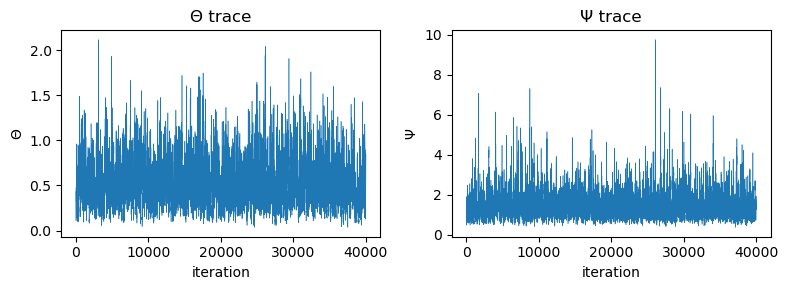

In [59]:
#6.3 c and d

# ------------------------------------------------------------
#  Bayesian normal-mean / variance example
#  posterior density  +  Metropolis–Hastings sampler
# ------------------------------------------------------------
import math, random
import numpy as np
from matplotlib import pyplot as plt

# ----------  (a)  one prior draw and (b) one synthetic sample ----------
rho = 0.5                       # prior correlation between log-Theta & log-Psi
xi,  gamma = np.random.multivariate_normal(
        mean=[0,0],
        cov=[[1, rho],[rho, 1]]
)                               # (ξ,γ)  ~  N(0,Σ)
theta0 = math.exp(xi)           # Θ  = e^ξ   ( strictly positive )
psi0   = math.exp(gamma)        # Ψ  = e^γ   ( strictly positive )

np.random.seed(123)             # reproducibility for the toy data set
data   = np.random.normal(loc=theta0, scale=math.sqrt(psi0), size=10)  # n = 10
n      = len(data)
ybar   = data.mean()
s2     = data.var(ddof=1)
print(f"truth: Θ={theta0:.3f}, Ψ={psi0:.3f}   |   sample mean={ybar:.3f},  s²={s2:.3f}")

# ----------  (c)  un-normalised log-posterior density ----------
def log_prior(theta, psi):
    """Bivariate N(0,1) on (log θ, log ψ) with ρ = 0.5  (unnormalised)."""
    if theta <= 0 or psi <= 0:
        return -math.inf
    xi, gamma = math.log(theta), math.log(psi)
    q  = xi**2 - 2*rho*xi*gamma + gamma**2
    return -0.5*q/(1 - rho**2)

def log_likelihood(theta, psi):
    """Normal(θ,ψ) likelihood for the fixed data sample (unnormalised)."""
    if psi <= 0:
        return -math.inf
    ss = ((data - theta)**2).sum()
    return -0.5*n*math.log(psi) - 0.5*ss/psi

def log_posterior(theta, psi):
    return log_prior(theta, psi) + log_likelihood(theta, psi)

# ----------  (d)  very plain Metropolis-Hastings on (log θ, log ψ) ----------
draws  = 50_000
burn   = 10_000
keep   = draws - burn
log_sd = 0.20                    # step–size on the log-scale  (~20 % moves)

cur_t, cur_p = ybar, s2          # sensible starting point: sample estimates
chain = []

for k in range(draws):
    # propose in log–space  (log-normal random-walk)
    prop_t = cur_t * math.exp(np.random.normal(scale=log_sd))
    prop_p = cur_p * math.exp(np.random.normal(scale=log_sd))

    log_acc = log_posterior(prop_t, prop_p) - log_posterior(cur_t, cur_p)
    if math.log(random.random()) < log_acc:      # accept
        cur_t, cur_p = prop_t, prop_p

    if k >= burn:
        chain.append((cur_t, cur_p))

chain = np.array(chain)          # shape (keep, 2)  – columns Θ, Ψ

print(f"\nposterior means  Θ̂={chain[:,0].mean():.3f}, Ψ̂={chain[:,1].mean():.3f}")

# ----------  quick visual check ----------
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(chain[:,0], lw=.4);  ax[0].set_title('Θ trace'); ax[0].set_ylabel('Θ')
ax[1].plot(chain[:,1], lw=.4);  ax[1].set_title('Ψ trace'); ax[1].set_ylabel('Ψ')
for a in ax: a.set_xlabel('iteration')
plt.tight_layout(); plt.show()

n=  10  → posterior means  Θ̂=1.505, Ψ̂=1.725
n= 100  → posterior means  Θ̂=1.897, Ψ̂=1.209
n=1000  → posterior means  Θ̂=1.844, Ψ̂=0.924


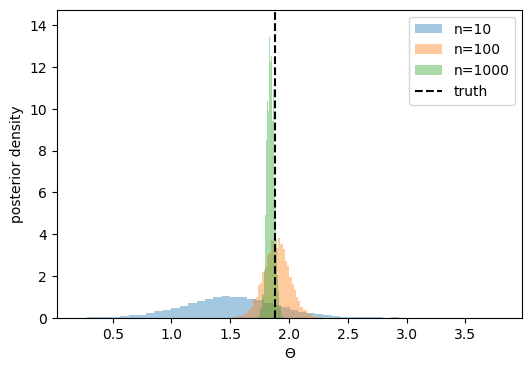

In [67]:
# ---------- put everything that depends on the DATA in a function ----------
def mh_posterior_draws(data, draws=50_000, burn=10_000, log_sd=0.20):
    """Return an (draws-burn, 2) array of MH samples for (Θ,Ψ)."""
    n  = len(data)                          # sample size now varies
    ȳ  = data.mean()
    s2 = data.var(ddof=1)

    # --- log–posterior pieces, identical apart from n, data, ȳ, s2 ---
    def log_prior(theta, psi):              # unchanged
        if theta<=0 or psi<=0: return -math.inf
        xi, γ = math.log(theta), math.log(psi)
        q  = xi**2 - 2*rho*xi*γ + γ**2       # rho = 0.5 from earlier
        return -0.5*q/(1-rho**2)

    def log_like(theta, psi):
        if psi<=0: return -math.inf
        return -0.5*n*math.log(psi) - 0.5*((data-theta)**2).sum()/psi

    def log_post(theta,psi):                # closure captures n & data
        return log_prior(theta,psi) + log_like(theta,psi)

    # --- MH loop (same as before) ---
    cur_t, cur_p = ȳ, s2                   # start at sample estimates
    keep = draws - burn
    chain = np.empty((keep,2))

    for k in range(draws):
        prop_t = cur_t * math.exp(np.random.normal(scale=log_sd))
        prop_p = cur_p * math.exp(np.random.normal(scale=log_sd))
        if math.log(random.random()) < log_post(prop_t,prop_p) - log_post(cur_t,cur_p):
            cur_t, cur_p = prop_t, prop_p
        if k >= burn:
            chain[k-burn] = (cur_t, cur_p)
    return chain
# ---------------------------------------------------------------------------

# ---------- still the SAME true parameters from 3(a) ----------
true_theta, true_psi = theta0, psi0          # drawn earlier

# ---------- (e)   run for n = 10, 100, 1000 ------------------
sizes   = [10, 100, 1000]
chains  = {}

for n in sizes:
    np.random.seed(123)                      # keep comparability
    sample = np.random.normal(loc=true_theta,
                              scale=math.sqrt(true_psi),
                              size=n)
    chains[n] = mh_posterior_draws(sample)   # store raw chains
    print(f"n={n:4d}  → posterior means  Θ̂={chains[n][:,0].mean():.3f}, "
          f"Ψ̂={chains[n][:,1].mean():.3f}")

# quick visual comparison of the marginal posterior for Θ
plt.figure(figsize=(6,4))
for n,c in chains.items():
    plt.hist(c[:,0], bins=50, density=True, alpha=.4, label=f'n={n}')
plt.axvline(true_theta, color='k', ls='--', label='truth')
plt.xlabel('Θ'); plt.ylabel('posterior density'); plt.legend(); plt.show()

In [50]:
# Cell 1: Imports and Function Definitions
# ---------------------------------------------------------------------------
# This block contains all the setup and helper functions.
# Run this cell first to make the functions available.
# ---------------------------------------------------------------------------
import math, random
import numpy as np
from matplotlib import pyplot as plt

def get_log_posterior_func(data, rho):
    """
    Creates and returns the log-posterior function for a given dataset.
    This is a closure, so the returned function has 'data' and 'n' baked in.
    """
    n = len(data)
    
    def log_posterior(theta, psi):
        """Calculates the un-normalised log-posterior."""
        if theta <= 0 or psi <= 0:
            return -np.inf
        
        # Part 1: Log-Likelihood of the data given the parameters
        log_lik = -0.5 * n * np.log(psi) - 0.5 * ((data - theta)**2).sum() / psi
        
        # Part 2: Log-Prior of the parameters (with correct Jacobian term)
        log_t, log_p = np.log(theta), np.log(psi)
        q = log_t**2 - 2 * rho * log_t * log_p + log_p**2
        log_pri = -0.5 * q / (1 - rho**2) - log_t - log_p
        
        return log_lik + log_pri
    
    return log_posterior

def mh_sampler(data, rho, draws=60000, burn=10000, log_sd=0.2):
    """
    Runs a Metropolis-Hastings sampler to draw from the posterior.
    """
    # Get the specific log-posterior function for this dataset
    log_post = get_log_posterior_func(data, rho)
    
    # Start the chain at a sensible point (the sample estimates)
    cur_t = data.mean()
    cur_p = data.var()
    if cur_p == 0: cur_p = 1.0 # Avoid starting with zero variance

    chain = []
    # Main MCMC loop
    for k in range(draws):
        # Propose new parameters using a log-normal random walk
        prop_t = cur_t * np.exp(np.random.normal(scale=log_sd))
        prop_p = cur_p * np.exp(np.random.normal(scale=log_sd))

        # Calculate acceptance probability
        log_acc_ratio = log_post(prop_t, prop_p) - log_post(cur_t, cur_p)
        
        # Accept or reject the proposal
        if np.log(random.random()) < log_acc_ratio:
            cur_t, cur_p = prop_t, prop_p

        # Store the sample after burn-in
        if k >= burn:
            chain.append((cur_t, cur_p))
            
    return np.array(chain)

True Parameters: Theta = 2.288, Psi = 1.390

n=  10 | Posterior Means: Theta_hat=2.227, Psi_hat=1.622
n= 100 | Posterior Means: Theta_hat=2.376, Psi_hat=1.416
n=1000 | Posterior Means: Theta_hat=2.302, Psi_hat=1.376


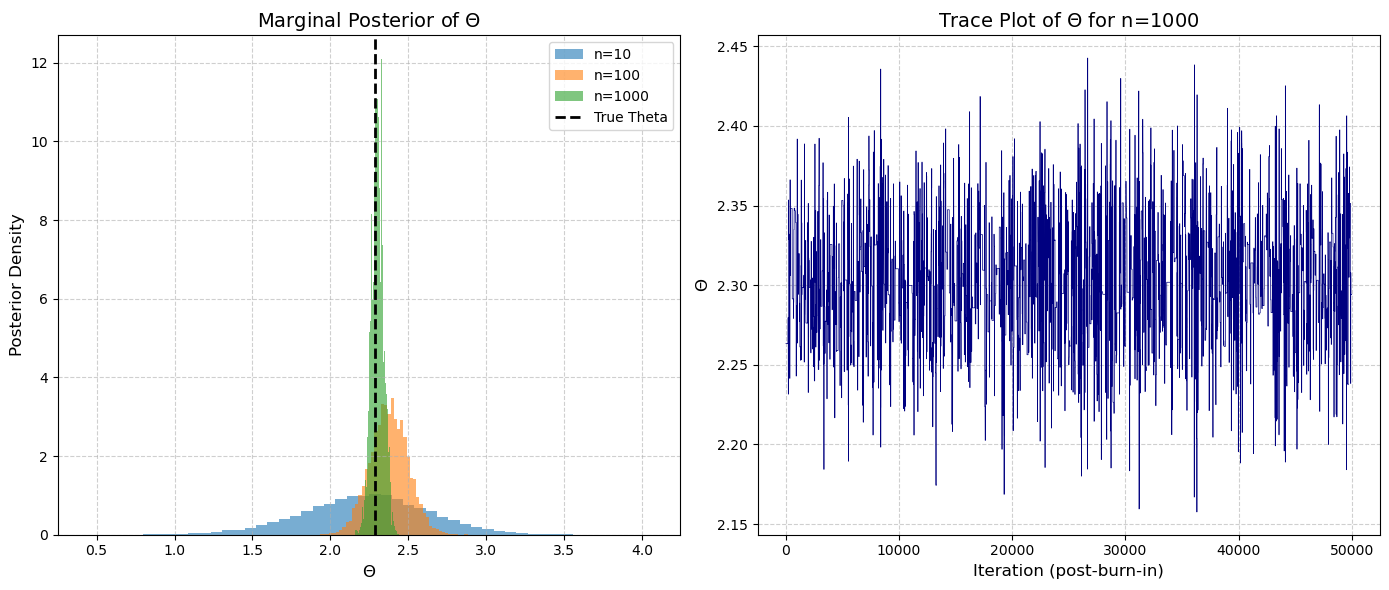

In [53]:

# --- (a) & (b) Generate the single "true" set of parameters ---
rho = 0.5
np.random.seed(456) # Use a fixed seed for reproducible results
xi, gamma = np.random.multivariate_normal(mean=[0,0], cov=[[1, rho],[rho, 1]])
true_theta = np.exp(xi)
true_psi   = np.exp(gamma)

# --- (d) & (e) Run sampler for n = 10, 100, 1000 ---
sizes = [10, 100, 1000]
chains = {}
print(f"True Parameters: Theta = {true_theta:.3f}, Psi = {true_psi:.3f}\n")

for n in sizes:
    # Generate a new synthetic dataset for each size n
    sample = np.random.normal(loc=true_theta, scale=np.sqrt(true_psi), size=n)
    
    # Run the MCMC sampler
    chains[n] = mh_sampler(sample, rho)
    
    # Calculate and print posterior means
    post_mean_t = chains[n][:,0].mean()
    post_mean_p = chains[n][:,1].mean()
    print(f"n={n:4d} | Posterior Means: Theta_hat={post_mean_t:.3f}, Psi_hat={post_mean_p:.3f}")

# --- Plotting the Results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Marginal posterior histograms for Theta
for n, c in chains.items():
    ax1.hist(c[:,0], bins=50, density=True, alpha=0.6, label=f'n={n}')
ax1.axvline(true_theta, color='k', ls='--', lw=2, label='True Theta')
ax1.set_title('Marginal Posterior of $\Theta$', fontsize=14)
ax1.set_xlabel('$\Theta$', fontsize=12)
ax1.set_ylabel('Posterior Density', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)


# Right plot: Trace plot for n=1000 case to show good mixing
ax2.plot(chains[1000][:,0], lw=0.5, color='navy')
ax2.set_title('Trace Plot of $\Theta$ for n=1000', fontsize=14)
ax2.set_xlabel('Iteration (post-burn-in)', fontsize=12)
ax2.set_ylabel('$\Theta$', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()

